# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

<span style="font-width:bold; font-size: 1.4rem;">This notebook explains how to create a feature view, create a training dataset, train a model and save it in the Hopsworks Model Registry.</span>

## 🗒️ This notebook is divided into the following sections:

1. Fetch Feature Groups.
2. Create a Feature View.
3. Create a Training Dataset.
4. Train a model.
5. Save trained model in the Model Registry.

![part2](images/02_training-dataset.png)

In [4]:
# connect to Hopsworks

import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connection closed.
2024-09-18 20:09:02,088 INFO: Python Engine initialized.

Logged in to project, explore it here https://hopsworks0.logicalclocks.com/p/119


## Create a Feature view

In [5]:
# Get departures feature groups

departures_fg = fs.get_feature_group("departures", 2)
departures_agg_30m_fg = fs.get_feature_group("departures_agg_30m", 1)
departures_agg_1h_fg = fs.get_feature_group("departures_agg_1h", 1)
departures_agg_6h_fg = fs.get_feature_group("departures_agg_6h", 1)

In [4]:
# Feature selection - define a Query for the Feature view

skip_agg_cols = ["departure_id", "site_id", "state", "journey_state", "journey_prediction_state"]
select_agg_cols = ["state_issue_count", "deviations_count_mean", "deviations_importance_mean", "late_count"]

query = departures_fg.select_except(skip_agg_cols) \
                     .join(departures_agg_30m_fg.select(select_agg_cols), left_on=["departure_id"], right_on=["departure_agg_id"], prefix="d30m_", join_type="inner") \
                     .join(departures_agg_1h_fg.select(select_agg_cols), left_on=["departure_id"], right_on=["departure_agg_id"], prefix="d1h_", join_type="inner") \
                     .join(departures_agg_6h_fg.select(select_agg_cols), left_on=["departure_id"], right_on=["departure_agg_id"], prefix="d6h_", join_type="inner")

query.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,scheduled,expected,deviations_count,deviations_importance_max,late,d30m_state_issue_count,d30m_deviations_count_mean,d30m_deviations_importance_mean,d30m_late_count,d1h_state_issue_count,d1h_deviations_count_mean,d1h_deviations_importance_mean,d1h_late_count,d6h_state_issue_count,d6h_deviations_count_mean,d6h_deviations_importance_mean,d6h_late_count
0,2024-09-18 02:31:00+00:00,2024-09-18 02:31:00+00:00,0.0,0.0,False,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,2024-09-18 02:53:30+00:00,2024-09-18 02:53:43+00:00,0.0,0.0,True,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,2024-09-18 02:19:00+00:00,2024-09-18 02:18:07+00:00,0.0,0.0,True,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,2024-09-18 02:59:45+00:00,2024-09-18 02:59:52+00:00,0.0,0.0,True,4.0,0.043478,0.304348,0.0,9.0,2.021739,14.152174,0.0,18.0,5.510870,38.576088,0.0
4,2024-09-18 03:00:30+00:00,2024-09-18 03:00:30+00:00,1.0,7.0,False,3.0,0.032609,0.228261,0.0,5.0,1.016304,7.114130,0.0,5.0,1.016304,7.114130,0.0


In [6]:
# Create the Feature view

feature_view = fs.get_or_create_feature_view(
    name='departures_agg',
    version=1,
    query=query,
    labels=["late"]
)

In [15]:
# Test get feature vector

feature_view.get_feature_vector({"departure_id": "9295-2024-09-18T04:53:30+02:00"})

## Create a Training Dataset

In [6]:
# Get existing feature view

feature_view = fs.get_feature_view(name='departures_agg', version=1)

In [7]:
# Create a Training dataset

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.5
)

X_train.head(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 
2024-09-18 20:09:15,133 WARNING: VersionWarning: Incremented version to `5`.



,scheduled,expected,deviations_count,deviations_importance_max,d30m_state_issue_count,d30m_deviations_count_mean,d30m_deviations_importance_mean,d30m_late_count,d1h_state_issue_count,d1h_deviations_count_mean,d1h_deviations_importance_mean,d1h_late_count,d6h_state_issue_count,d6h_deviations_count_mean,d6h_deviations_importance_mean,d6h_late_count
2,2024-09-18 02:53:30+00:00,2024-09-18 02:53:43+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2024-09-18 06:24:00+00:00,2024-09-18 06:25:01+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0
6,2024-09-18 06:05:00+00:00,2024-09-18 06:05:55+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2024-09-18 06:29:00+00:00,2024-09-18 06:30:37+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2024-09-18 06:10:32+00:00,2024-09-18 06:11:41+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
y_train.head(5)

,late
2,True
5,True
6,True
7,True
9,True


## Train a model to predict delays

In [9]:
# Necessary imports

import os
import joblib

import datetime

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [10]:
# Apply model-dependent transformations

from functions.common_functions import convert_date_to_unix

X_train["scheduled"] = X_train["scheduled"].apply(convert_date_to_unix)
X_test["scheduled"] = X_test["scheduled"].apply(convert_date_to_unix)

X_train["expected"] = X_train["expected"].apply(convert_date_to_unix)
X_test["expected"] = X_test["expected"].apply(convert_date_to_unix)

In [11]:
X_train.head(5)

,scheduled,expected,deviations_count,deviations_importance_max,d30m_state_issue_count,d30m_deviations_count_mean,d30m_deviations_importance_mean,d30m_late_count,d1h_state_issue_count,d1h_deviations_count_mean,d1h_deviations_importance_mean,d1h_late_count,d6h_state_issue_count,d6h_deviations_count_mean,d6h_deviations_importance_mean,d6h_late_count
2,1726628010000,1726628023000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1726640640000,1726640701000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0
6,1726639500000,1726639555000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1726640940000,1726641037000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1726639832000,1726639901000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Create an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(enable_categorical=True)

# Fit the XGBoost Regressor to the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# Predict target values on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("⛳️ MSE:", mse)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("⛳️ RMSE:", rmse)

# Calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("⛳️ R^2:", r2)

⛳️ MSE: 0.23076019
⛳️ RMSE: 0.48037505
⛳️ R^2: -0.2999490859867382


In [17]:
# Create a DataFrame 'df_' to store true and predicted values for evaluation
df_pred = pd.DataFrame({
    "y_true": y_test["late"],
    "y_pred": y_pred,
})

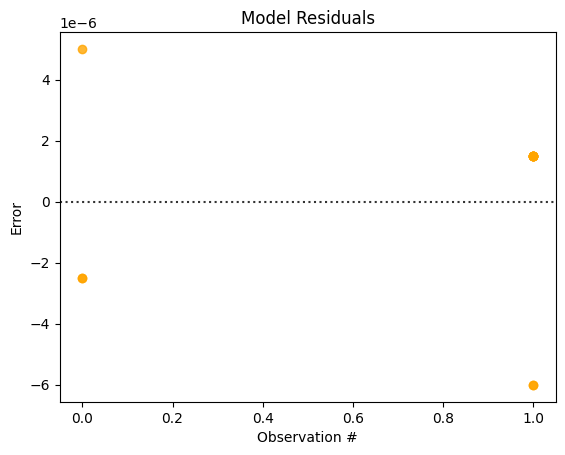

In [18]:
# Create a residual plot using Seaborn
residplot = sns.residplot(data=df_pred, x="y_true", y="y_pred", color='orange')

# Add title, xlabel, and ylabel to the residual plot
plt.title('Model Residuals')
plt.xlabel('Observation #')
plt.ylabel('Error')

# Display the residual plot
plt.show()

# Get the figure from the residual plot and displaying it separately
fig = residplot.get_figure()
fig.show()

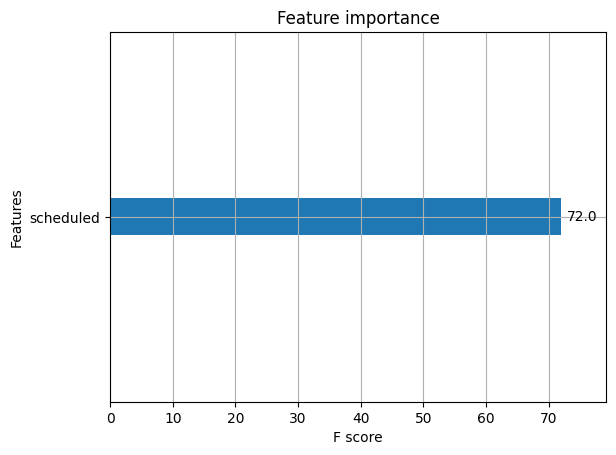

In [19]:
# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    xgb_regressor, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

## Save model into the Model Registry

In [3]:
# Retrieve the model registry
mr = project.get_model_registry()

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Create input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Create a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Convert the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [22]:
# Create a directory for the model artifacts if it doesn't exist
model_dir = "late_departure_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save the label encoder and XGBoost regressor as joblib files in the model directory
joblib.dump(xgb_regressor, model_dir + '/xgboost_regressor.pkl')

# Save the residual plot figure as an image in the model directory
fig.savefig(model_dir + "/residplot.png")

In [23]:
# Create a Python model in the model registry named 'air_quality_xgboost_model'
ld_model = mr.python.create_model(
    name="late_departure_model", 
    metrics={
        "RMSE": float(rmse),
        "MSE": float(mse),
        "R squared": float(r2),
    },
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Late departures predictor",
)

# Save the model artifacts to the 'air_quality_model' directory in the model registry
ld_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/191 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1513 elapsed<00:00 remaining<?

Model created, explore it at https://hopsworks0.logicalclocks.com/p/119/models/late_departure_model/4


Model(name: 'late_departure_model', version: 4)